# Trajectory Optimization Example 2

This is an extension to Trajectory Optimization Example where we use velocity measurements at interpolated times to optimize a trajectory.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(6, suppress=True)

from pylgmath import so3op, se3op, Transformation
from pysteam.trajectory import Time, TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver, DoglegGaussNewtonSolver
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable import vspace as vspaceev

## Part 1

This part is exactly the same as the previous example. We use the interpolated velocities from this part as measurements for the trajectory we will be optimizing in part 2.

Options:


In [2]:
num_states = 2  # total number of states
dt = 1

Set up the trajectory that uses a constant velocity motion prior:


In [3]:
# states with initial conditions and associated timestamps
states = [(dt * i, Transformation(), 0.1 * i * np.ones((6, 1))) for i in range(num_states)]

# wrap states with corresponding steam state variables (no copying!)
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
state_vars[0][1].locked = True
state_vars[0][2].locked = True
state_vars[1][2].locked = True

# construct a trajectory
Qc_inv = np.diag(1 / np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))  # smoothing factor diagonal
traj = TrajectoryInterface(Qc_inv=Qc_inv)
for t, T_vi, w_iv_inv in state_vars:
  traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)

Construct the optimization problem and solve:


In [4]:
opt_prob = OptimizationProblem()
opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
opt_prob.add_cost_term(*traj.get_prior_cost_terms())

solver = DoglegGaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()

Begin Optimization
------------------
Number of States:  1
Number of Cost Terms:  1
Initial Cost:  0.12000000000000002
Iteration:    1  -  Cost:     0.0300  -  TR Shrink:  0.000  -  AvP Ratio:  1.000  -  Dogleg Segment: Gauss Newton   
Iteration:    2  -  Cost:     0.0300  -  TR Shrink: 50.000  -  AvP Ratio:  0.000  -  Dogleg Segment: Gauss Newton   
Termination Cause:  CONVERGED ZERO GRADIENT
Total Optimization Time: 0.0781 seconds


Print out results:


In [5]:
print("First Pose:                 \n", states[0][1])
print("Last Pose:                  \n", states[-1][1])
print("First Vel:                  \n", states[0][2].T)
print("Last Vel:                   \n", states[-1][2].T)
print("Interp. Vel (t=t0+0.5*dT):  \n",
      traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=0.5 * dt)).evaluate().T)


First Pose:                 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Last Pose:                  
 [[ 0.997502 -0.048688  0.051187  0.05    ]
 [ 0.051187  0.997502 -0.048688  0.05    ]
 [-0.048688  0.051187  0.997502  0.05    ]
 [ 0.        0.        0.        1.      ]]
First Vel:                  
 [[0. 0. 0. 0. 0. 0.]]
Last Vel:                   
 [[0.1 0.1 0.1 0.1 0.1 0.1]]
Interp. Vel (t=t0+0.5*dT):  
 [[0.05 0.05 0.05 0.05 0.05 0.05]]


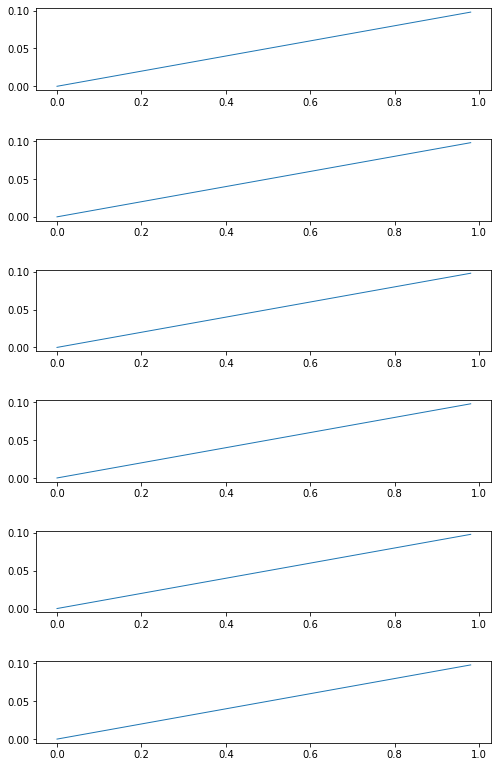

In [6]:
plot_times = lambda: np.arange(0.0, 1.0, 0.02)
plot_intp_vels = np.array(
    [traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=t * dt)).evaluate().squeeze() for t in plot_times()])

fig = plt.figure()

plot_number = 611
fig.set_size_inches(8, 12)
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.6)

for i in range(6):
  ax = fig.add_subplot(plot_number + i)
  ax.plot(plot_times(), plot_intp_vels[:, i].squeeze(), '-', linewidth=1.0)

## Part 2

Now we get velocities at the interpolated times. We then construct a second trajectory and optimize it with these measurements. You should see that the resulting trajectory is close to the first one.

In [7]:
meas_times = lambda: np.arange(0.1, 0.4, 0.2)
meas_intp_vels = [
    traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=t * dt)).evaluate() for t in meas_times()
]


Now create a new trajectory with only the first state locked.

In [8]:
## create another trajectory
# states with initial conditions and associated timestamps
states = [(dt * i, Transformation(), 0.1 * i * np.ones((6, 1))) for i in range(num_states)]

# wrap states with corresponding steam state variables (no copying!)
state_vars = [(t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states]
state_vars[0][1].locked = True
state_vars[0][2].locked = True

# construct a trajectory
Qc_inv = np.diag(1 / np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))  # smoothing factor diagonal
traj = TrajectoryInterface(Qc_inv=Qc_inv)
for t, T_vi, w_iv_inv in state_vars:
  traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)

opt_prob = OptimizationProblem()
opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
opt_prob.add_cost_term(*traj.get_prior_cost_terms())

noise_model = StaticNoiseModel(np.eye(6) * 0.0001)
loss_func = L2LossFunc()
for i, t in enumerate(meas_times()):
  intp_vel = traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=t * dt))
  error_func = vspaceev.add(VSpaceStateVar(meas_intp_vels[i], locked=True), vspaceev.neg(intp_vel))
  cost_term = WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
  opt_prob.add_cost_term(cost_term)

solver = DoglegGaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()

meas_intp_vel = traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=0.5 * dt)).evaluate()
print("Interp. Vel (t=t0+0.5*dT):  \n", meas_intp_vel.T)


Begin Optimization
------------------
Number of States:  2
Number of Cost Terms:  3
Initial Cost:  141.06000000000023
Iteration:    1  -  Cost:     0.0265  -  TR Shrink:  0.000  -  AvP Ratio:  1.000  -  Dogleg Segment: Gauss Newton   
Iteration:    2  -  Cost:     0.0265  -  TR Shrink: 50.000  -  AvP Ratio:  0.000  -  Dogleg Segment: Interp GN&GD   
Termination Cause:  CONVERGED ZERO GRADIENT
Total Optimization Time: 0.4524 seconds
Interp. Vel (t=t0+0.5*dT):  
 [[0.048178 0.048178 0.048178 0.048178 0.048178 0.048178]]


In [9]:
print("First Pose:                 \n", states[0][1])
print("Last Pose:                  \n", states[-1][1])
print("First Vel:                  \n", states[0][2].T)
print("Last Vel:                   \n", states[-1][2].T)
print("Interp. Vel (t=t0+0.5*dT):  \n",
      traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=0.5 * dt)).evaluate().T)

First Pose:                 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Last Pose:                  
 [[ 0.997808 -0.045684  0.047876  0.046832]
 [ 0.047876  0.997808 -0.045684  0.046832]
 [-0.045684  0.047876  0.997808  0.046832]
 [ 0.        0.        0.        1.      ]]
First Vel:                  
 [[0. 0. 0. 0. 0. 0.]]
Last Vel:                   
 [[0.088277 0.088277 0.088277 0.088277 0.088277 0.088277]]
Interp. Vel (t=t0+0.5*dT):  
 [[0.048178 0.048178 0.048178 0.048178 0.048178 0.048178]]


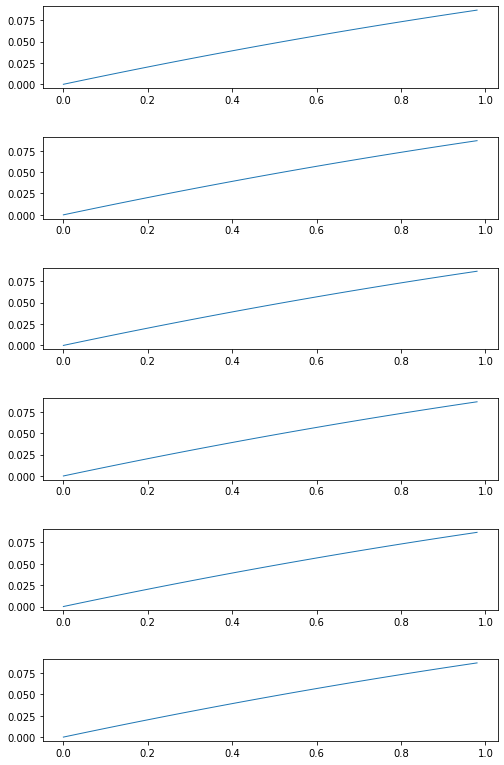

In [10]:
plot_times = lambda: np.arange(0.0, 1.0, 0.02)
plot_intp_vels = np.array(
    [traj.get_velocity_interpolator(Time(states[0][0]) + Time(secs=t * dt)).evaluate().squeeze() for t in plot_times()])

fig = plt.figure()

plot_number = 611
fig.set_size_inches(8, 12)
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.6)

for i in range(6):
  ax = fig.add_subplot(plot_number + i)
  ax.plot(plot_times(), plot_intp_vels[:, i].squeeze(), '-', linewidth=1.0)